WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


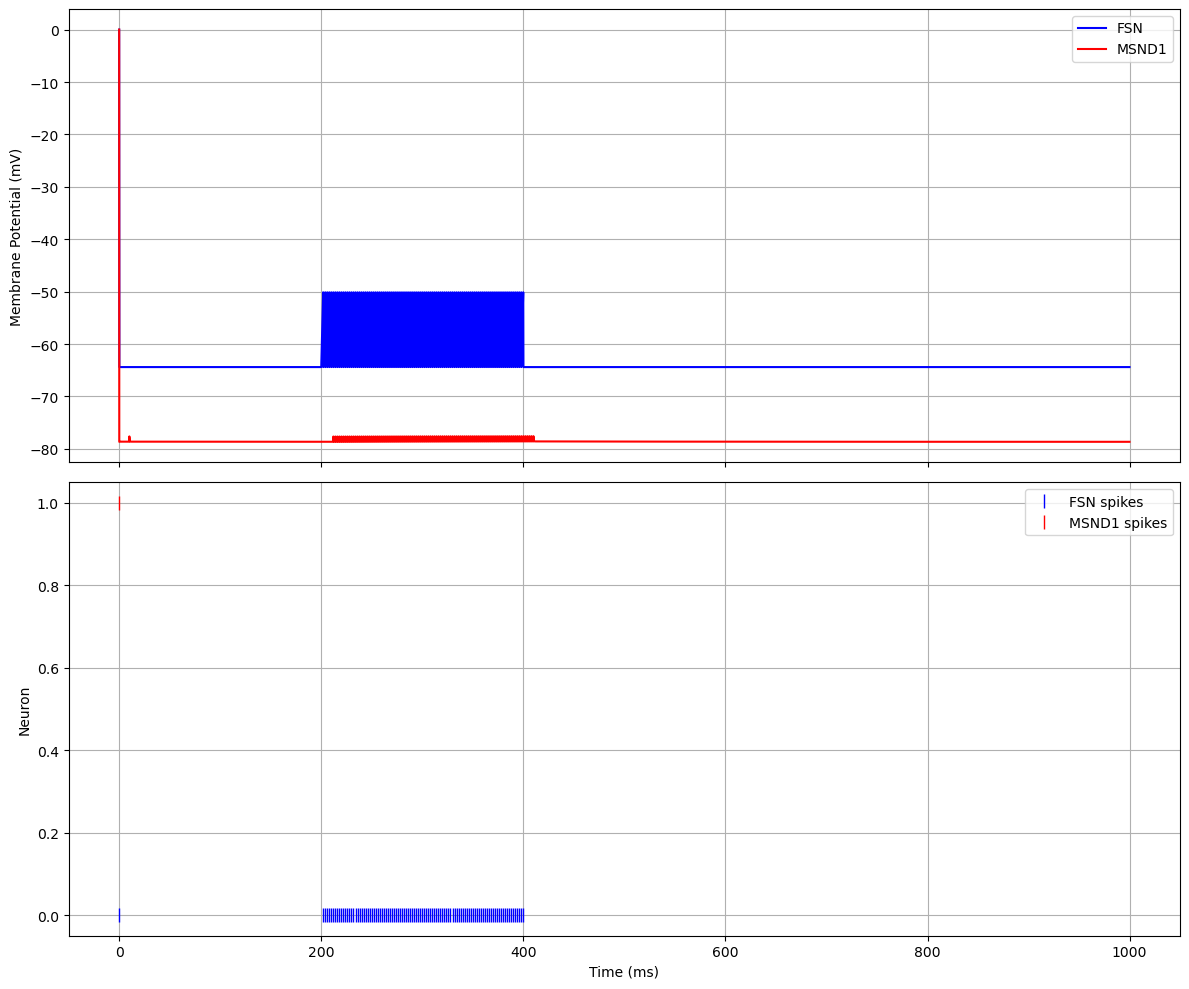

In [3]:
# check delay effect 

from brian2 import *
import matplotlib.pyplot as pltㅣ

# 기본 설정
defaultclock.dt = 0.1*ms
start_scope()

# 뉴런 파라미터 설정
FSN_params = {
    'vr': -64.4*mV,
    'vt': -50*mV,
    'k': 1,
    'u': 0 * mV/ms,
    'th': 25 * mV,
    'a': 0.2 * 1/ms,
    'b': 0.025 * 1/ms,
    'C': 80 * pF
}

MSND1_params = {
    'vr': -78.663*mV,
    'vt': -29.7*mV,
    'k': 1,
    'u': 0 * mV/ms,
    'th': 40 * mV,
    'a': 0.01 * 1/ms,
    'b': -20 * 1/ms,
    'C': 15.2 * pF
}

# 뉴런 모델 정의
neuron_eqs = '''
dv / dt = (k*1*pF/ms/mV*(v-vr)*(v-vt) - u*pF + I - I_syn) / C : volt (unless refractory)
du/dt = a * (b * (v - vr) - u) : volt/second

I_syn = I_AMPA + I_NMDA + I_GABA: amp
I_GABA  : amp
I_AMPA : amp
I_NMDA : amp
a : 1/second
b : 1/second
k : 1
vt     : volt
vr     : volt 
th     : volt
C      : farad
I      : amp
d       : volt/second
'''

# 뉴런 그룹 생성
poisson_eq = '30*Hz + (t >= 200*ms) * (t < 400*ms) * 1000*Hz + 3*Hz * randn()'
P = PoissonGroup(1, rates=poisson_eq)
FSN = NeuronGroup(1, neuron_eqs, threshold='v>vt', reset='v=vr', method='euler')
MSND1 = NeuronGroup(1, neuron_eqs, threshold='v>vt', reset='v=vr', method='euler')

# 파라미터 설정
for param, value in FSN_params.items():
    setattr(FSN, param, value)
for param, value in MSND1_params.items():
    setattr(MSND1, param, value)

# 시냅스 연결
syn = Synapses(FSN, MSND1, model='''
    g0_g : siemens
    E_GABA : volt
    w : 1
    tau_GABA : second
    dg_g/dt = -g_g / tau_GABA : siemens (clock-driven)
    I_GABA_syn = w * g_g * (E_GABA - v) : amp
    I_syn_syn = I_GABA_syn : amp
    ''',
    on_pre='''
    v_post += w * mV
    g_g += g0_g
    ''')

syn.connect()
syn.g0_g = 6*nS
syn.tau_GABA = 11*ms
syn.E_GABA = -74*mV
syn.w = 1
syn.delay = 10*ms  

# 모니터 설정
P_mon = SpikeMonitor(P)
FSN_mon = StateMonitor(FSN, 'v', record=True)
MSND1_mon = StateMonitor(MSND1, 'v', record=True)
FSN_spikes = SpikeMonitor(FSN)
MSND1_spikes = SpikeMonitor(MSND1)


net = Network(P, FSN, MSND1, syn, 
              P_mon, FSN_mon, MSND1_mon, FSN_spikes, MSND1_spikes)

FSN.I = 0 * pA
net.run(200*ms)

FSN.I = 636 * pA
net.run(200*ms)

FSN.I = 0 * pA
net.run(600*ms)


# 결과 시각화
def plot_results():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Membrane potential 
    ax1.plot(FSN_mon.t/ms, FSN_mon.v[0]/mV, label='FSN', color='blue')
    ax1.plot(MSND1_mon.t/ms, MSND1_mon.v[0]/mV, label='MSND1', color='red')
    ax1.set_ylabel('Membrane Potential (mV)')
    ax1.legend()
    ax1.grid(True)

    if len(FSN_spikes.t) > 0:
        ax2.plot(FSN_spikes.t/ms, np.zeros_like(FSN_spikes.t), '|', color='blue', 
                label='FSN spikes', markersize=10)
    if len(MSND1_spikes.t) > 0:
        ax2.plot(MSND1_spikes.t/ms, np.ones_like(MSND1_spikes.t), '|', color='red', 
                label='MSND1 spikes', markersize=10)
    ax2.set_ylabel('Neuron')
    ax2.set_xlabel('Time (ms)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_results()

![Normal Result](results/raster_plots/raster_plot_normal.png)

![PD Result](results/raster_plots/raster_plot_pd.png)